### Import libraries

In [50]:
!pip3 install scikit-learn==0.23

In [51]:
import numpy as np
import matplotlib.pyplot as plt 

import pandas as pd  
import seaborn as sns 
from sklearn.model_selection import train_test_split

### Load dataset

In [52]:
# dataset url
url = "https://raw.githubusercontent.com/SaiHarshaK/Assignments/master/7th%20sem/foml/Assgn%201/HorseKicks.tsv"
horse_kicks_dt = pd.read_csv(url, sep="\t") # read tsv file

In [53]:
X = horse_kicks_dt["Year"]
Y = horse_kicks_dt.drop(["Year"],axis=1)
print(Y) # We can see the dataset here for validity

    GC  C1  C2  C3  C4  C5  C6  C7  C8  C9  C10  C11  C14  C15
0    0   0   0   0   0   0   0   1   1   0    0    0    1    0
1    2   0   0   0   1   0   0   0   0   0    0    0    1    1
2    2   0   0   0   0   0   1   1   0   0    1    0    2    0
3    1   2   2   1   1   0   0   0   0   0    1    0    1    0
4    0   0   0   1   1   2   2   0   1   0    0    2    1    0
5    0   3   2   1   1   1   0   0   0   2    1    4    3    0
6    1   0   0   2   1   0   0   1   0   1    0    0    0    0
7    1   2   0   0   0   0   1   0   1   1    2    1    4    1
8    0   0   1   2   0   1   2   1   0   1    0    3    0    0
9    3   0   1   0   0   0   0   1   0   0    2    0    1    1
10   0   0   0   0   0   0   1   0   0   2    0    1    0    1
11   2   1   0   0   1   1   1   0   0   1    0    1    3    0
12   1   1   2   1   0   0   3   2   1   1    0    1    2    0
13   0   1   1   0   0   1   1   0   0   0    0    1    1    0
14   0   0   1   1   0   1   1   0   0   1    2    2   

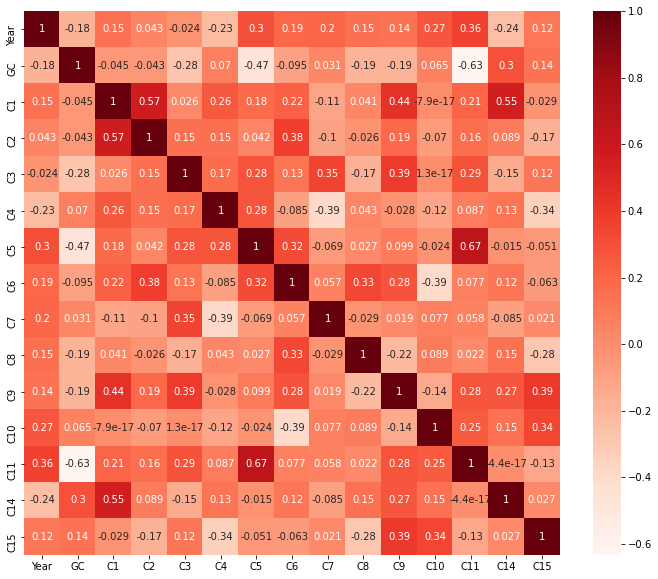

In [54]:
# Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = horse_kicks_dt.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# Here we dont see much correaltion with year feature

Train - test Split

In [55]:
# Split data into training set and test set
X_train = X[0:13]
Y_train = Y[0:13]
X_test = X[13:]
Y_test = Y[13:]
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(13,)
(7,)
(13, 14)
(7, 14)


Using maximum likelihood estimation to learn the parameters.

In [56]:
class Poisson_Predictor_ML:

    """
    A class used to represent Poisson Predictor for Maximum Likelihood

    ...

    Attributes
    ----------
    params : list
        Parameters for Poisson Function
    lam_ml : list
        Lambda Parameter for Poisson Function

    Methods
    -------
    fit(X, Y)
        learns the parameters from given Input and Output Labels
    predict(x)
      returns prediction for each corp for all input points
      a 2d matrix where each row represents prediction for respective corps.
    """

    def fit(self, X, Y):
        """learns the parameters from given Input and Output Labels
      
        Parameters
        ----------
        X : list
            input features
        Y : list
            observations for the input points for every corp

        """
    # find params for corps
        params = Y.values.mean(axis=0)
        print("params ", params)
        self.params = params
        self.lam_ml = params

    def predict(self, x):
        """predicts for each corp for all input points

        Parameters
        ----------
        X : list
            input features of datapoints

        """
        # since data doesnt have any features we use the expected value (lam_ml) as the predicted value
        return np.array([self.lam_ml] * len(x))

In [57]:
# returns sigma(RMSE) for true and predicted values
def mean_squared_error(Y_true, Y_pred):
  return np.square(np.subtract(Y_true,Y_pred)).mean() 

In [58]:
# initialize model
model = Poisson_Predictor_ML()
model.fit(X_train, Y_train)

params  [1.         0.69230769 0.61538462 0.61538462 0.46153846 0.38461538
 0.84615385 0.53846154 0.30769231 0.69230769 0.53846154 1.
 1.46153846 0.30769231]


In [59]:
y_test_predict = model.predict(X_test)
y_test_ml_pred_corps = y_test_predict[0] # predicted values per corp
# Using transpose for ease over iterating corps
Y_test_corps = np.array(Y_test.T)
y_test_predict_corps = y_test_predict.T
rmse_ml = [] # calculate rmse for each corp
for i in range(len(Y_test_corps)): # for each corp
  # print(Y_train_corps[i])
  # print(y_train_predict_corps[i])
  rmse_ml.append((np.sqrt(mean_squared_error(Y_test_corps[i], y_test_predict_corps[i]))))

Using maximum aposteriori estimation to learn the parameters

In [60]:
class Poisson_Predictor_MAP:
    """
    A class used to represent Poisson Predictor for MAP

    ...

    Attributes
    ----------
    params : list
        Parameters for Poisson Function
    lam_ml : list
        Lambda Parameter for Poisson Function
    alpha : int
        parameter for prior function
    beta : int
        parameter for prior function

    Methods
    -------
    fit(X, Y)
        learns the parameters from given Input and Output Labels
    predict(x)
      returns prediction for each corp for all input points
      a 2d matrix where each row represents prediction for respective corps.
    """
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta

    def fit(self, X, Y):
        """learns the parameters from given Input and Output Labels

        Parameters
        ----------
        X : list
            input features
        Y : list
            observations for the input points for every corp

        """
        # find params for corps
        # mode for gamma dist
        params = (Y.values.sum(axis=0) + self.alpha - 1) / (len(Y) + self.beta)
        self.params = params
        self.lam_ml = params

    def predict(self, x):
        """predicts for each corp for all input points

        Parameters
        ----------
        X : list
            input features of datapoints

        """
        # since data doesnt have any features we use the expected value (lam_ml) as the predicted value
        return np.array([self.lam_ml] * len(x))

In [61]:
# find the best hyper paramteres alpha and beta
alpha = list(range(1, 11))
beta = list(range(1, 11))

tuning_results = []
for a in alpha:
  for b in beta:
    model = Poisson_Predictor_MAP(a, b)
    model.fit(X_train, Y_train)

    y_train_predict = model.predict(X_train)

    # Using transpose for ease over iterating corps
    Y_train_corps = np.array(Y_train.T)
    y_train_predict_corps = y_train_predict.T
    rmse_map = [] # calculate rmse for each corp
    for i in range(len(Y_train_corps)): # for each corp
      # print(Y_train_corps[i])
      # print(y_train_predict_corps[i])
      rmse_map.append((np.sqrt(mean_squared_error(Y_train_corps[i], y_train_predict_corps[i]))))

    tuning_results.append((sum(rmse_map), (a, b)))

# best hyperparameters
_, (alpha, beta) = min(tuning_results, key = lambda t: t[0])

print("Best hyper-parameters: {", " alpha: ", alpha, ", beta: ", beta, "}")

# print Y-map x rmse
model = Poisson_Predictor_MAP(alpha, beta)
model.fit(X_train, Y_train)

y_test_predict = model.predict(X_test)
y_test_map_pred_corps = y_test_predict[0] # predicetd values per corp

# Using transpose for ease over iterating corps
Y_test_corps = np.array(Y_test.T)
y_test_predict_corps = y_test_predict.T
rmse_map = [] # calculate rmse for each corp
for i in range(len(Y_test_corps)): # for each corp
  rmse_map.append((np.sqrt(mean_squared_error(Y_test_corps[i], y_test_predict_corps[i]))))
rmse_map

Best hyper-parameters: {  alpha:  2 , beta:  1 }


[0.7559289460184544,
 1.1065666703449761,
 0.7319250547113999,
 0.7319250547113999,
 0.5,
 0.5532833351724881,
 0.989743318610787,
 0.8921425711997711,
 0.5,
 0.7423074889580902,
 1.142857142857143,
 1.1338934190276817,
 1.0,
 0.9285714285714286]

In [62]:
# print table for MLE estimate and MAP estimate
from tabulate import tabulate

index = list(range(len(rmse_ml)))
results_table = tabulate(zip(index, y_test_ml_pred_corps, rmse_ml, y_test_map_pred_corps, rmse_map), headers=["Corp #", "λ_ml", "rmse", "λ_map", "rmse"])
print(results_table)

  Corp #      λ_ml      rmse     λ_map      rmse
--------  --------  --------  --------  --------
       0  1         0.755929  1         0.755929
       1  0.692308  1.11244   0.714286  1.10657
       2  0.615385  0.729756  0.642857  0.731925
       3  0.615385  0.729756  0.642857  0.731925
       4  0.461538  0.484764  0.5       0.5
       5  0.384615  0.587989  0.428571  0.553283
       6  0.846154  0.989804  0.857143  0.989743
       7  0.538462  0.898011  0.571429  0.892143
       8  0.307692  0.509421  0.357143  0.5
       9  0.692308  0.738393  0.714286  0.742307
      10  0.538462  1.15969   0.571429  1.14286
      11  1         1.13389   1         1.13389
      12  1.46154   1.02381   1.42857   1
      13  0.307692  0.941214  0.357143  0.928571


## **Graphs**

Prior Distribution

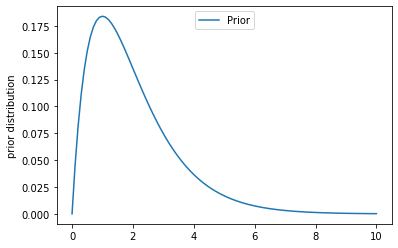

(Prior)Maxima at:  1.0


In [63]:
import math 

def getPrior(alpha, beta, lam):
  return (beta**alpha)*(lam**(alpha-1))*(math.exp(-beta * lam)) /  (math.factorial(alpha))

x = np.linspace(0, 10, 101)
y = [getPrior(alpha, beta, val) for val in x]

plt.plot(x, y, label='Prior')
plt.ylabel('prior distribution')
plt.legend(loc=9)
plt.show()
print("(Prior)Maxima at: ", x[y.index(max(y))])

Likelihood distribution

In [64]:
def getLikelihood(lam, Y):
  ans = 1
  for y in Y:
    ans = ans * math.exp(-lam) * (lam**y) / math.factorial(y)
  return ans

Posterior Distribution

In [65]:
def getPosterior(alpha, beta, lam, Y):
  return getPrior(alpha, beta, lam) * getLikelihood(lam, Y)

Corp 2

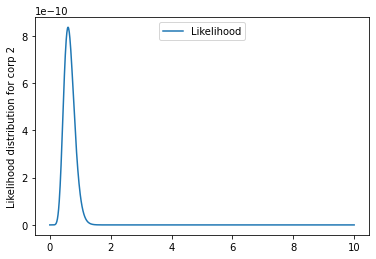

(Likelihood)Maxima at:  0.6


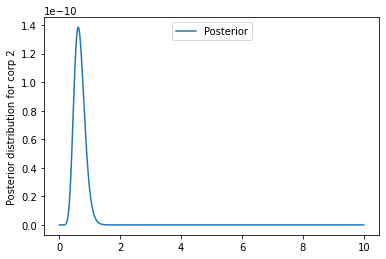

(Posterior)Maxima at:  0.62


In [66]:
# x = list(range(0, 101, 1))
x = np.linspace(0, 10, 1001)
y_like = [getLikelihood(val, Y["C2"]) for val in x]
y_pos = [getPosterior(alpha, beta, val, Y["C2"]) for val in x]

plt.plot(x, y_like, label='Likelihood')
plt.legend(loc=9)
plt.ylabel('Likelihood distribution for corp 2')
plt.show()
print("(Likelihood)Maxima at: ", x[y_like.index(max(y_like))])

plt.plot(x, y_pos, label='Posterior')
plt.legend(loc=9)
plt.ylabel('Posterior distribution for corp 2')
plt.show()

print("(Posterior)Maxima at: ", x[y_pos.index(max(y_pos))])

Corp 4

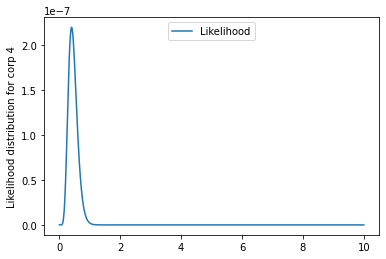

(Likelihood)Maxima at:  0.4


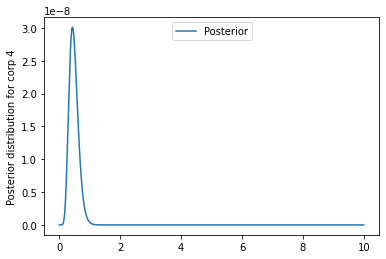

(Posterior)Maxima at:  0.43


In [67]:
y_like = [getLikelihood(val, Y["C4"]) for val in x]
y_pos = [getPosterior(alpha, beta, val, Y["C4"]) for val in x]

plt.plot(x, y_like, label='Likelihood')
plt.legend(loc=9)
plt.ylabel('Likelihood distribution for corp 4')
plt.show()
print("(Likelihood)Maxima at: ", x[y_like.index(max(y_like))])

plt.plot(x, y_pos, label='Posterior')
plt.legend(loc=9)
plt.ylabel('Posterior distribution for corp 4')
plt.show()

print("(Posterior)Maxima at: ", x[y_pos.index(max(y_pos))])

Corp 6

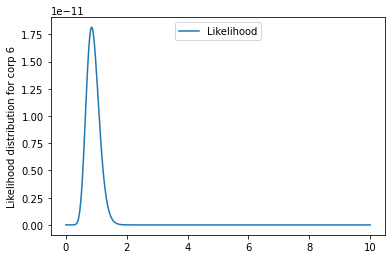

(Likelihood)Maxima at:  0.85


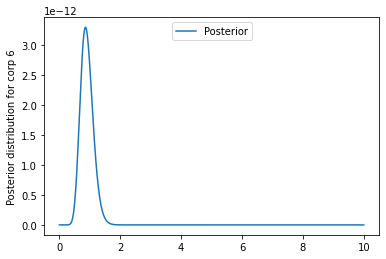

(Posterior)Maxima at:  0.86


In [68]:
y_like = [getLikelihood(val, Y["C6"]) for val in x]
y_pos = [getPosterior(alpha, beta, val, Y["C6"]) for val in x]


plt.plot(x, y_like, label='Likelihood')
plt.legend(loc=9)
plt.ylabel('Likelihood distribution for corp 6')
plt.show()
print("(Likelihood)Maxima at: ", x[y_like.index(max(y_like))])

plt.plot(x, y_pos, label='Posterior')
plt.legend(loc=9)
plt.ylabel('Posterior distribution for corp 6')
plt.show()

print("(Posterior)Maxima at: ", x[y_pos.index(max(y_pos))])